### Part 2 II: Machine Learning

***10. Use unsupervised, modern ML techniques such as random forest (your choice, but explain why you chose a particular technique, and limit your choices to what was covered in class) and repeat your previous analysis for daily factor returns. Is there a difference between the simpler and more complex approach?***

***13. Now extend the original data set provided to the present and report the out-ofsample results for your signal.***


***Our Approach***

* ***Predict the direction of the market 1 day ahead using lag features of the ff.csv files factors.***
* ***Train it on 1926-2018 period and test for period 2018-20. to validate use K- fold cross validation.***
* ***Now using a simple long short strategy - go long when you think market will me up tommorrow and short when you think market will be down.***
* ***Analyse the portfolio values and returns on yearly basis for both training and testing period***
* ***Calculate max drawdowns for both the period.***

***Reason's to choose Random Forest***

***Random forest is an ensemble of multiple decision trees. Decision trees are one of those few algorithms which mimics the human thinking process. Markets heavily depends on personal experience & knowledge and how the trader thinks before making any trading decision. To mimic this process, we have choose something on the grounds of Decision Trees method. But the downside of Decision Trees is the overfitting and high bias. So, to overcome this, some sort of ensemble of decision trees can allow to reduce market noise which is equivalent ot thousand of traders interecting and making decsiosn in the same market. Random forest perfectly resembles this phenomena and hence our first and only contender to build a model***


In [130]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib as mlt
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import seaborn as sns
from IPython.display import Image

%config InlineBackend.figure_format = 'svg'
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import datetime

In [131]:
def cal_perc_missing(df, title = '', rotate_angle = 0, figsize = (10,3)):
    miss_per = pd.DataFrame(df.isnull().sum(axis =0)*100/df.shape[0], columns=['Missing %']).round(2).sort_values(by=['Missing %'], ascending=False)
    display(miss_per.T)
    plt.figure(figsize = figsize)
    plt.xticks(rotation = rotate_angle)
    plt.title(title)
    plt.ylabel('Missing %')
    plt.xlabel('Features')
    _ = plt.bar(x = miss_per.index, height=miss_per['Missing %'], width=0.3)

def z_scaling(df):
    return((df - df.mean())/df.std())

def heatmap(df, annot = True, shape = (10,8)):
    plt.figure(figsize = shape)
    mask = np.triu(df.corr())
    ax = sns.heatmap(df.corr(), annot = annot, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', fmt='.1g', mask = mask)
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)

In [132]:
df = pd.read_csv('ffcurrent.csv',skiprows=4,parse_dates= ["Unnamed: 0"], index_col = ["Unnamed: 0"])[:-1]
df.index = pd.to_datetime(df.index)
df

,Mkt-RF,SMB,HML,RF
1926-07-01,0.10,-0.24,-0.28,0.009
1926-07-02,0.45,-0.32,-0.08,0.009
1926-07-06,0.17,0.27,-0.35,0.009
1926-07-07,0.09,-0.59,0.03,0.009
1926-07-08,0.21,-0.36,0.15,0.009
...,...,...,...,...
2020-11-23,0.83,0.85,1.55,0.000
2020-11-24,1.56,-0.15,2.74,0.000
2020-11-25,0.03,0.01,-1.27,0.000
2020-11-27,0.43,0.45,-1.66,0.000


In [133]:
df.describe()

,Mkt-RF,SMB,HML,RF
count,24874.000000,24874.000000,24874.000000,24874.000000
mean,0.030147,0.004600,0.014005,0.012287
std,1.078497,0.585839,0.604692,0.011919
min,-17.440000,-11.620000,-5.980000,-0.003000
25%,-0.400000,-0.250000,-0.240000,0.001000
50%,0.060000,0.020000,0.000000,0.010000
75%,0.490000,0.270000,0.260000,0.020000
max,15.760000,8.210000,8.430000,0.061000


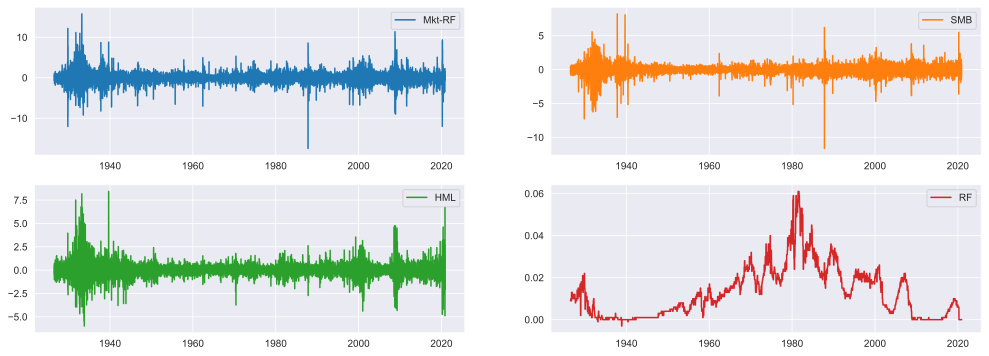

In [134]:
temp = df
x = math.ceil(temp.shape[1]/2)
temp.plot(figsize = (17,3*x), subplots = True, sharex = False, layout=(x,2));

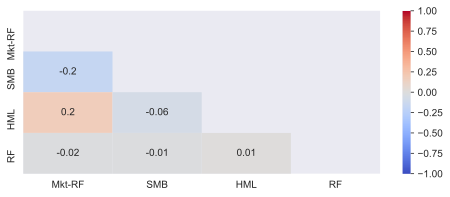

In [135]:
heatmap(df, shape = (8,3))

***Not a huge correlation we can see from ***

In [136]:
list(df.columns)

['Mkt-RF', 'SMB', 'HML', 'RF']

In [137]:
# lag for all columns 1 day 
for col in list(df.columns): df['lag_'+ col] = df[col].shift(1)

# lag for previous 5 days of MKt-RF
for lag in range(2,6): df['lag_' + str(lag) + '_Mkt-RF'] = df['Mkt-RF'].shift(lag)
    
# adding previous 60 day vol
df['roll_60_day_vol'] = df['lag_Mkt-RF'].rolling(60).std()
    
df

,Mkt-RF,SMB,HML,RF,lag_Mkt-RF,lag_SMB,lag_HML,lag_RF,lag_2_Mkt-RF,lag_3_Mkt-RF,lag_4_Mkt-RF,lag_5_Mkt-RF,roll_60_day_vol
1926-07-01,0.10,-0.24,-0.28,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-07-02,0.45,-0.32,-0.08,0.009,0.10,-0.24,-0.28,0.009,NaN,NaN,NaN,NaN,NaN
1926-07-06,0.17,0.27,-0.35,0.009,0.45,-0.32,-0.08,0.009,0.10,NaN,NaN,NaN,NaN
1926-07-07,0.09,-0.59,0.03,0.009,0.17,0.27,-0.35,0.009,0.45,0.10,NaN,NaN,NaN
1926-07-08,0.21,-0.36,0.15,0.009,0.09,-0.59,0.03,0.009,0.17,0.45,0.10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,0.83,0.85,1.55,0.000,-0.51,0.69,-0.61,0.000,0.59,-0.93,-0.19,1.22,1.365823
2020-11-24,1.56,-0.15,2.74,0.000,0.83,0.85,1.55,0.000,-0.51,0.59,-0.93,-0.19,1.366923
2020-11-25,0.03,0.01,-1.27,0.000,1.56,-0.15,2.74,0.000,0.83,-0.51,0.59,-0.93,1.380010
2020-11-27,0.43,0.45,-1.66,0.000,0.03,0.01,-1.27,0.000,1.56,0.83,-0.51,0.59,1.375939


In [138]:
df_rf = df[['Mkt-RF', 'lag_Mkt-RF', 'lag_SMB', 'lag_HML', 'lag_RF', 'lag_2_Mkt-RF', 'lag_3_Mkt-RF', 'lag_4_Mkt-RF', 'lag_5_Mkt-RF', 'roll_60_day_vol']].dropna()
df_rf['signal'] = df_rf.apply(lambda row: 1 if row['Mkt-RF']>0 else 0 , axis=1)
df_rf['signal'] = df_rf['signal'].astype('category')
df_rf['weekday'] = df_rf.index.dayofweek
df_rf

,Mkt-RF,lag_Mkt-RF,lag_SMB,lag_HML,lag_RF,lag_2_Mkt-RF,lag_3_Mkt-RF,lag_4_Mkt-RF,lag_5_Mkt-RF,roll_60_day_vol,signal,weekday
1926-09-14,0.90,-0.03,-0.11,0.50,0.009,-0.44,-0.83,-0.07,-0.51,0.519111,1,1
1926-09-15,-0.21,0.90,-0.62,0.09,0.009,-0.03,-0.44,-0.83,-0.07,0.529606,0,2
1926-09-16,-0.18,-0.21,0.40,-0.19,0.009,0.90,-0.03,-0.44,-0.83,0.529085,0,3
1926-09-17,-1.01,-0.18,-0.33,0.10,0.009,-0.21,0.90,-0.03,-0.44,0.530114,0,4
1926-09-18,0.70,-1.01,-0.16,-0.28,0.009,-0.18,-0.21,0.90,-0.03,0.548602,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,0.83,-0.51,0.69,-0.61,0.000,0.59,-0.93,-0.19,1.22,1.365823,1,0
2020-11-24,1.56,0.83,0.85,1.55,0.000,-0.51,0.59,-0.93,-0.19,1.366923,1,1
2020-11-25,0.03,1.56,-0.15,2.74,0.000,0.83,-0.51,0.59,-0.93,1.380010,1,2
2020-11-27,0.43,0.03,0.01,-1.27,0.000,1.56,0.83,-0.51,0.59,1.375939,1,4


In [139]:
df_rf.dtypes

Mkt-RF              float64
lag_Mkt-RF          float64
lag_SMB             float64
lag_HML             float64
lag_RF              float64
lag_2_Mkt-RF        float64
lag_3_Mkt-RF        float64
lag_4_Mkt-RF        float64
lag_5_Mkt-RF        float64
roll_60_day_vol     float64
signal             category
weekday               int64
dtype: object

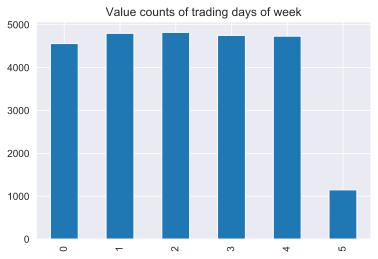

In [140]:
_ = df_rf['weekday'].value_counts().sort_index().plot(kind = 'bar',
                                                      title = 'Value counts of trading days of week')

In [141]:
pd.DataFrame(df_rf.groupby([df_rf.index.year, 'weekday']).count()['signal'])

signal
     weekday        
1926 0            15
     1            14
     2            16
     3            15
     4            16
...              ...
2020 0            44
     1            47
     2            47
     3            47
     4            46

[502 rows x 1 columns]

,Mkt-RF,lag_Mkt-RF,lag_SMB,lag_HML,lag_RF,lag_2_Mkt-RF,lag_3_Mkt-RF,lag_4_Mkt-RF,lag_5_Mkt-RF,roll_60_day_vol,signal,weekday
1926-09-14,0.90,-0.03,-0.11,0.50,0.009,-0.44,-0.83,-0.07,-0.51,0.519111,1,1
1926-09-15,-0.21,0.90,-0.62,0.09,0.009,-0.03,-0.44,-0.83,-0.07,0.529606,0,2
1926-09-16,-0.18,-0.21,0.40,-0.19,0.009,0.90,-0.03,-0.44,-0.83,0.529085,0,3
1926-09-17,-1.01,-0.18,-0.33,0.10,0.009,-0.21,0.90,-0.03,-0.44,0.530114,0,4
1926-09-20,-0.64,0.70,-0.28,-0.11,0.009,-1.01,-0.18,-0.21,0.90,0.554403,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,0.83,-0.51,0.69,-0.61,0.000,0.59,-0.93,-0.19,1.22,1.365823,1,0
2020-11-24,1.56,0.83,0.85,1.55,0.000,-0.51,0.59,-0.93,-0.19,1.366923,1,1
2020-11-25,0.03,1.56,-0.15,2.74,0.000,0.83,-0.51,0.59,-0.93,1.380010,1,2
2020-11-27,0.43,0.03,0.01,-1.27,0.000,1.56,0.83,-0.51,0.59,1.375939,1,4


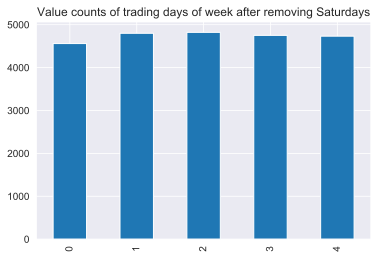

In [142]:
df_rf = df_rf[df_rf['weekday'] != 5]
df_rf['weekday'].value_counts().sort_index().plot(kind = 'bar',
                                                  title = 'Value counts of trading days of week after removing Saturdays')
df_rf

In [143]:
train = df_rf[df_rf.index <= '2018-07-31']
test = df_rf[df_rf.index > '2018-07-31']

In [144]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint

In [97]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

param_grid = {
    #'bootstrap': [True],  #
    'max_depth': [20, 50, 80, 90, 100, 110], # max possible depth of the tree 
    'max_features': [2, 3, 4, 6],  # max I can chose here is 4. ideal shoud be sqrt
    'min_samples_leaf': [3, 4, 5, 10],  # min no of sample sinn last leafs
    'min_samples_split': [8, 10, 12, 20], # no of sample reequired at a node to make a further split 
    'n_estimators': [100, 200, 300, 500]  # no of decision trees in each iteration
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 10, return_train_score=True)


In [98]:
x_col = ['lag_Mkt-RF', 'lag_SMB', 'lag_HML', 'lag_RF', 'lag_2_Mkt-RF', 'lag_3_Mkt-RF', 'lag_4_Mkt-RF', 'lag_5_Mkt-RF', 'roll_60_day_vol']
y_col = ['signal']
grid_search.fit(train[x_col], train[y_col])

Fitting 3 folds for each of 1536 candidates, totalling 4608 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [146]:
# saving the model file first in case kernee gets shutout randomly. 
import joblib
#joblib.dump(grid_search, 'model.pkl')
model = joblib.load("model.pkl")
model

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [147]:
model.best_params_

{'max_depth': 50,
 'max_features': 3,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 500}

In [148]:
model.best_score_

0.5418811986241745

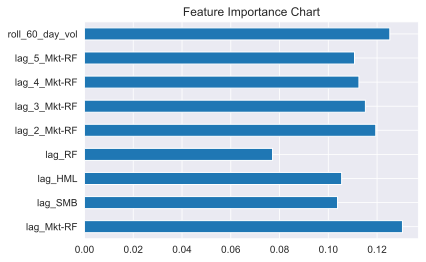

In [149]:
feat_importances = pd.Series(model.best_estimator_.feature_importances_, index= x_col)
_ = feat_importances.plot(kind='barh', title = 'Feature Importance Chart')

***The feature importance chart is assuming all the variables having almost similar importance, which highly suggest of very less predictablity in each of these features***

In [150]:
model

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [151]:
pd.DataFrame(model.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,13.440123,1.776253,0.557114,0.032235,20,2,3,8,100,"{'max_depth': 20, 'max_features': 2, 'min_samp...",...,0.545372,0.513781,0.531828,0.013284,1454,0.975949,0.987910,0.976406,0.980088,0.005534
1,26.011994,1.389784,1.084720,0.045694,20,2,3,8,200,"{'max_depth': 20, 'max_features': 2, 'min_samp...",...,0.549272,0.511700,0.534601,0.016405,1024,0.983164,0.990185,0.980045,0.984465,0.004240
2,35.717480,1.717857,1.565524,0.070227,20,2,3,8,300,"{'max_depth': 20, 'max_features': 2, 'min_samp...",...,0.555902,0.511050,0.535988,0.018652,667,0.981409,0.990900,0.977771,0.983360,0.005535
3,61.270888,0.986496,2.895934,0.149138,20,2,3,8,500,"{'max_depth': 20, 'max_features': 2, 'min_samp...",...,0.553042,0.515471,0.536681,0.015717,473,0.984724,0.991615,0.979591,0.985310,0.004926
4,12.498846,0.508088,0.541809,0.027289,20,2,3,10,100,"{'max_depth': 20, 'max_features': 2, 'min_samp...",...,0.546542,0.515731,0.533301,0.012946,1274,0.968279,0.983035,0.966006,0.972440,0.007549


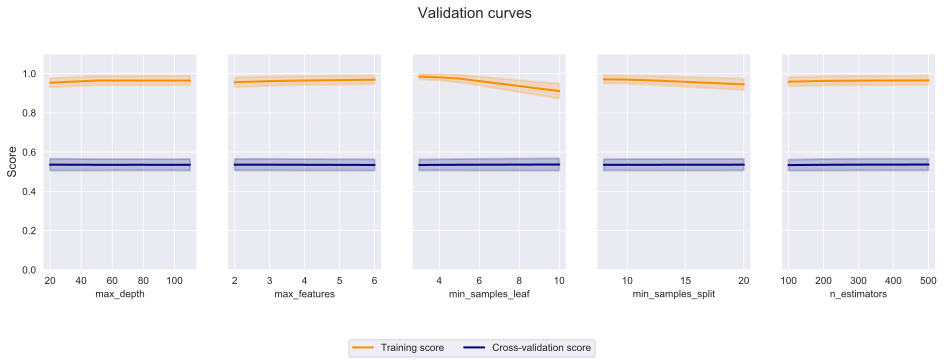

In [152]:
df = pd.DataFrame(model.cv_results_)
results = ['mean_test_score','mean_train_score','std_test_score', 'std_train_score']

def pooled_var(stds):
    n = 3 
    return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))

fig, axes = plt.subplots(1, len(model.param_grid), 
                         figsize = (3.2*len(model.param_grid), 5),
                         sharey='row')
axes[0].set_ylabel("Score", fontsize=12)


for idx, (param_name, param_range) in enumerate(model.param_grid.items()):
    grouped_df = df.groupby(f'param_{param_name}')[results].agg({'mean_train_score': 'mean',
                                                                  'mean_test_score': 'mean',
                                                                  'std_train_score': pooled_var,
                                                                  'std_test_score': pooled_var
                                                                 })
    
    previous_group = df.groupby(f'param_{param_name}')[results]
    axes[idx].set_xlabel(param_name, fontsize=10)
    axes[idx].set_ylim(0.0, 1.1)
    lw = 2
    
    axes[idx].plot(param_range,
                   grouped_df['mean_train_score'],
                   label="Training score",
                   color="darkorange", lw=lw)
    
    axes[idx].fill_between(param_range,
                           grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                           grouped_df['mean_train_score'] + grouped_df['std_train_score'], alpha=0.2,
                           color="darkorange", lw=lw)
    
    axes[idx].plot(param_range, 
                   grouped_df['mean_test_score'], 
                   label="Cross-validation score",
                   color="navy", 
                   lw=lw)
    
    axes[idx].fill_between(param_range,
                           grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                           grouped_df['mean_test_score'] + grouped_df['std_test_score'], alpha=0.2,
                           color="navy", 
                           lw=lw)

handles, labels = axes[0].get_legend_handles_labels()
fig.suptitle('Validation curves', fontsize=15)
fig.legend(handles, labels, loc=8, ncol=2, fontsize=10)

fig.subplots_adjust(bottom=0.25, top=0.85)  
plt.show()

***A Validation Curve is an important diagnostic tool that shows the sensitivity between to changes in a model's accuracy with change in some parameter of the model. A validation curve is typically drawn between some parameter of the model and the model's score.***

***Conclusion - As we can see that from the above validation curves that even though training scores are reaching almost full accuracy, validation curves are almost being stagnant with almost fixed vol around them. (refer to bolliner bands above). YHis highly suggests that in the current schemen of things, the way the model i being designed, there is abpsultely no predictive power in model.***

In [153]:
from sklearn.metrics import classification_report
test_clf_report = pd.DataFrame(classification_report(test['signal'],
                                   model.predict(test[x_col]),
                                   output_dict = True))

train_clf_report = pd.DataFrame(classification_report(train['signal'],
                                   model.predict(train[x_col]),
                                   output_dict = True))

display('Training Period Classification Report ', train_clf_report)
display('Testing Period Classification Report ', test_clf_report)

'Training Period Classification Report '

,0,1,accuracy,macro avg,weighted avg
precision,0.963913,0.889243,0.920267,0.926578,0.923982
recall,0.860842,0.971963,0.920267,0.916403,0.920267
f1-score,0.909467,0.928765,0.920267,0.919116,0.919787
support,10736.000000,12341.000000,0.920267,23077.000000,23077.000000


'Testing Period Classification Report '

,0,1,accuracy,macro avg,weighted avg
precision,0.408163,0.533163,0.491497,0.470663,0.477253
recall,0.304183,0.643077,0.491497,0.473630,0.491497
f1-score,0.348584,0.582985,0.491497,0.465784,0.478142
support,263.000000,325.000000,0.491497,588.000000,588.000000


***Continuing a similar story, confusion metrics for training period are way better then that of testing period. Testing period acuuracy scores hinges on the boundry 
of the baselines model performance which is 50%***

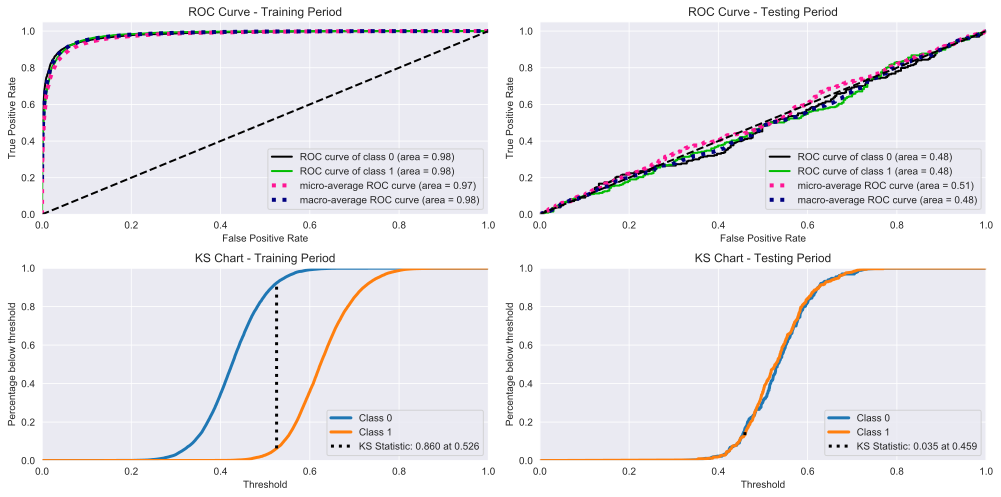

In [155]:
import scikitplot as skplt
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False,figsize=(14,7))

skplt.metrics.plot_roc(train[y_col],
                       model.predict_proba(train[x_col]),
                       title = 'ROC Curve - Training Period',
                       ax = ax[0,0])

skplt.metrics.plot_roc(test[y_col],
                       model.predict_proba(test[x_col]),
                       title = 'ROC Curve - Testing Period',
                       ax = ax[0,1])


skplt.metrics.plot_ks_statistic(train[y_col],
                       model.predict_proba(train[x_col]),
                       title = 'KS Chart - Training Period',
                       ax = ax[1,0])


skplt.metrics.plot_ks_statistic(test['signal'],
                       model.predict_proba(test[x_col]),
                       title = 'KS Chart - Testing Period',
                       ax = ax[1,1])

plt.tight_layout()

***AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes***

***K-S or Kolmogorov-Smirnov chart measures performance of classification models. More accurately, K-S is a measure of the degree of separation between the positive and negative distributions.***

***Conclusion from the above charts show that model was absolutely was not able to bi-furcate between classses***

In [159]:
train['pred_signal'] = model.predict(train[x_col])
test['pred_signal']  = model.predict(test[x_col])
test['pred_return']  = test.apply(lambda row: row['Mkt-RF']*1 if row['pred_signal'] == 1 else row['Mkt-RF']*-1 , axis=1)
train['pred_return'] = train.apply(lambda row: row['Mkt-RF']*1 if row['pred_signal'] == 1 else row['Mkt-RF']*-1 , axis=1)

In [160]:
train

,Mkt-RF,lag_Mkt-RF,lag_SMB,lag_HML,lag_RF,lag_2_Mkt-RF,lag_3_Mkt-RF,lag_4_Mkt-RF,lag_5_Mkt-RF,roll_60_day_vol,signal,weekday,pred_signal,pred_return
1926-09-14,0.90,-0.03,-0.11,0.50,0.009,-0.44,-0.83,-0.07,-0.51,0.519111,1,1,1,0.90
1926-09-15,-0.21,0.90,-0.62,0.09,0.009,-0.03,-0.44,-0.83,-0.07,0.529606,0,2,1,-0.21
1926-09-16,-0.18,-0.21,0.40,-0.19,0.009,0.90,-0.03,-0.44,-0.83,0.529085,0,3,0,0.18
1926-09-17,-1.01,-0.18,-0.33,0.10,0.009,-0.21,0.90,-0.03,-0.44,0.530114,0,4,0,1.01
1926-09-20,-0.64,0.70,-0.28,-0.11,0.009,-1.01,-0.18,-0.21,0.90,0.554403,0,0,1,-0.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-25,0.83,0.22,-1.35,0.40,0.008,0.15,-0.10,-0.34,0.27,0.583485,1,2,1,0.83
2018-07-26,-0.20,0.83,-0.43,-1.05,0.008,0.22,0.15,-0.10,-0.34,0.578854,0,3,1,-0.20
2018-07-27,-0.82,-0.20,0.66,0.58,0.008,0.83,0.22,0.15,-0.10,0.580171,0,4,0,0.82
2018-07-30,-0.70,-0.82,-1.36,1.11,0.008,-0.20,0.83,0.22,0.15,0.584826,0,0,0,0.70


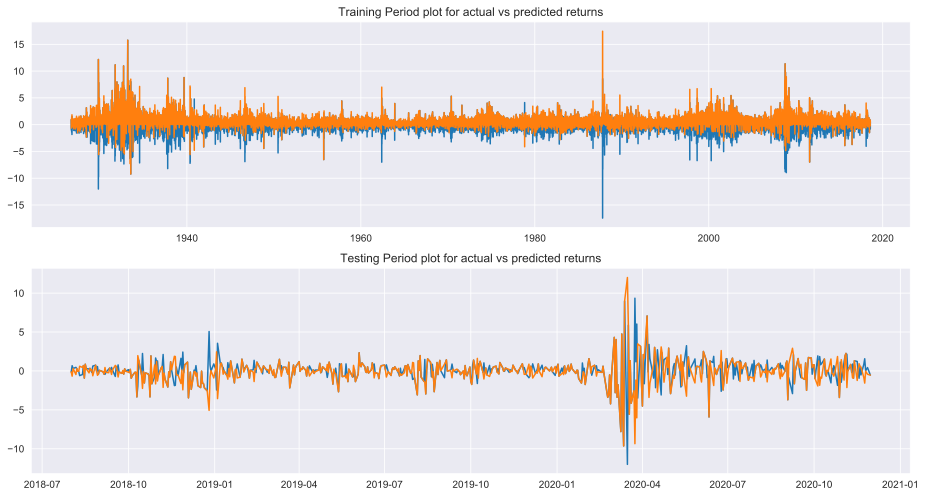

In [174]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(13,7))

axs[0].plot(train[['Mkt-RF', 'pred_return']])
axs[0].title.set_text('Training Period plot for actual vs predicted returns')

axs[1].plot(test[['Mkt-RF', 'pred_return']])
axs[1].title.set_text('Testing Period plot for actual vs predicted returns')

plt.tight_layout()

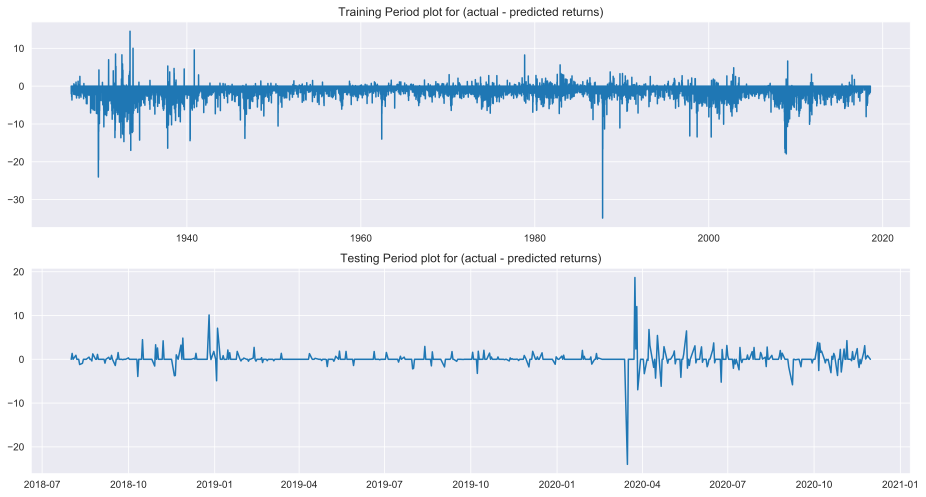

In [173]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(13,7))

axs[0].plot(train['Mkt-RF'] - train['pred_return'])
axs[0].title.set_text('Training Period plot for (actual - predicted returns)')

axs[1].plot(test['Mkt-RF'] - test['pred_return'])
axs[1].title.set_text('Testing Period plot for (actual - predicted returns)')

plt.tight_layout()

In [163]:
train

,Mkt-RF,lag_Mkt-RF,lag_SMB,lag_HML,lag_RF,lag_2_Mkt-RF,lag_3_Mkt-RF,lag_4_Mkt-RF,lag_5_Mkt-RF,roll_60_day_vol,signal,weekday,pred_signal,pred_return
1926-09-14,0.90,-0.03,-0.11,0.50,0.009,-0.44,-0.83,-0.07,-0.51,0.519111,1,1,1,0.90
1926-09-15,-0.21,0.90,-0.62,0.09,0.009,-0.03,-0.44,-0.83,-0.07,0.529606,0,2,1,-0.21
1926-09-16,-0.18,-0.21,0.40,-0.19,0.009,0.90,-0.03,-0.44,-0.83,0.529085,0,3,0,0.18
1926-09-17,-1.01,-0.18,-0.33,0.10,0.009,-0.21,0.90,-0.03,-0.44,0.530114,0,4,0,1.01
1926-09-20,-0.64,0.70,-0.28,-0.11,0.009,-1.01,-0.18,-0.21,0.90,0.554403,0,0,1,-0.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-25,0.83,0.22,-1.35,0.40,0.008,0.15,-0.10,-0.34,0.27,0.583485,1,2,1,0.83
2018-07-26,-0.20,0.83,-0.43,-1.05,0.008,0.22,0.15,-0.10,-0.34,0.578854,0,3,1,-0.20
2018-07-27,-0.82,-0.20,0.66,0.58,0.008,0.83,0.22,0.15,-0.10,0.580171,0,4,0,0.82
2018-07-30,-0.70,-0.82,-1.36,1.11,0.008,-0.20,0.83,0.22,0.15,0.584826,0,0,0,0.70


In [164]:
test

,Mkt-RF,lag_Mkt-RF,lag_SMB,lag_HML,lag_RF,lag_2_Mkt-RF,lag_3_Mkt-RF,lag_4_Mkt-RF,lag_5_Mkt-RF,roll_60_day_vol,signal,weekday,pred_signal,pred_return
2018-08-01,-0.13,0.51,0.83,-1.10,0.008,-0.70,-0.82,-0.20,0.83,0.573980,0,2,1,-0.13
2018-08-02,0.67,-0.13,0.07,-0.18,0.007,0.51,-0.70,-0.82,-0.20,0.573090,1,3,0,-0.67
2018-08-03,0.31,0.67,0.33,-0.69,0.007,-0.13,0.51,-0.70,-0.82,0.578025,1,4,1,0.31
2018-08-06,0.46,0.31,-1.07,0.53,0.007,0.67,-0.13,0.51,-0.70,0.569300,1,0,0,-0.46
2018-08-07,0.29,0.46,0.25,-0.34,0.007,0.31,0.67,-0.13,0.51,0.562847,1,1,1,0.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23,0.83,-0.51,0.69,-0.61,0.000,0.59,-0.93,-0.19,1.22,1.365823,1,0,0,-0.83
2020-11-24,1.56,0.83,0.85,1.55,0.000,-0.51,0.59,-0.93,-0.19,1.366923,1,1,0,-1.56
2020-11-25,0.03,1.56,-0.15,2.74,0.000,0.83,-0.51,0.59,-0.93,1.380010,1,2,0,-0.03
2020-11-27,0.43,0.03,0.01,-1.27,0.000,1.56,0.83,-0.51,0.59,1.375939,1,4,0,-0.43


In [165]:
def final_return_df(df):  
    ret_df = []
    for y in list(set(df.index.year)):
        temp = df[df.index.year == y]
        ret_df.append([y,
                       temp.shape[0],
                       ((1+(temp['pred_return']/100)).cumprod()[-1]-1)*100*252/temp.shape[0],
                       temp['pred_return'].std()*math.sqrt(temp.shape[0])
                      ])

    ret_df = pd.DataFrame(ret_df, columns=['year', 'trade_day_count', 'strat_return_yearly_adjust%', 'strat_vol_yearly_%'])
    ret_df = ret_df.set_index('year')
    return(ret_df)

,trade_day_count,strat_return_yearly_adjust%,strat_vol_yearly_%
year,,,
1926,76,115.425999,3.799799
1927,250,111.905171,7.254087
1928,250,279.647192,10.403904
1929,249,1720.254723,28.854693
1930,251,1139.889698,15.727580
...,...,...,...
2014,252,237.379608,9.118741
2015,252,404.254338,11.442972
2016,252,261.441318,10.989295


,trade_day_count,strat_return_yearly_adjust%,strat_vol_yearly_%
year,,,
2018,105,-82.377923,11.983487
2019,252,2.239553,13.152063
2020,231,-18.956810,34.483430


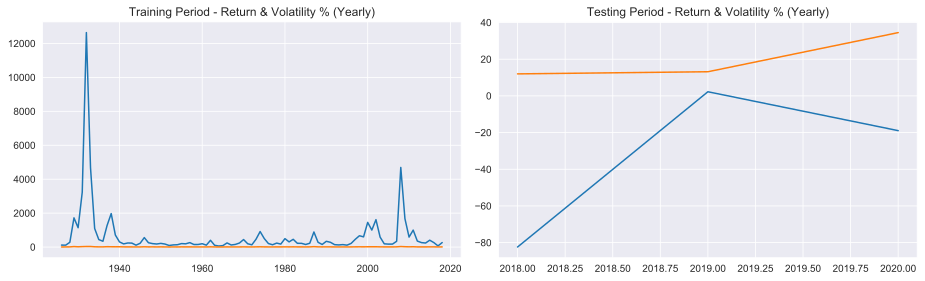

In [172]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(13,4))

axs[0].plot(final_return_df(train)[['strat_return_yearly_adjust%', 'strat_vol_yearly_%']])
display(final_return_df(train))
axs[0].title.set_text('Training Period - Return & Volatility % (Yearly)')

axs[1].plot(final_return_df(test)[['strat_return_yearly_adjust%', 'strat_vol_yearly_%']])
display(final_return_df(test))
axs[1].title.set_text('Testing Period - Return & Volatility % (Yearly)')

plt.tight_layout()

***Here also we can observe that therie is no consistencey in yearly returns and vol, as expected***

In [168]:
# display((1+ train['pred_return']/100).cumprod())
# display((1+ test['pred_return']/100).cumprod())

In [169]:
import scipy.stats as stats
def performance_stats(ts, freq='D'):
    # DrawDown characteristics
    index_lvl = (1.+ts).cumprod()
    daily_drawdown =  index_lvl.div(index_lvl.cummax()) - 1.
    max_daily_drawdown = daily_drawdown.expanding().min()
    daily_drawdown.name = 'drawdown'
    max_daily_drawdown.name = 'max_drawdown'
    mdd = max_daily_drawdown.min()

    drawdowns_df = pd.concat([daily_drawdown.to_frame(), max_daily_drawdown.to_frame(),
                              ], axis=1, join='outer')
    if freq == 'D': mult = 252
    elif freq == 'M': mult = 12
    else: mult = 1
    # Mean, Std
    adj_ts = ts
    mean, std = adj_ts.mean() * mult, adj_ts.std() * math.sqrt(mult)
    # Sharpe
    sharpe = mean/std
    # Sortino
    neg_ret = adj_ts[adj_ts<=0]
    neg_std = neg_ret.std()*mult
    sortino = mean/neg_std
    # Skew, Kurtosis
    skew, kurtosis = stats.skew(ts), stats.kurtosis(ts)
    i = max_daily_drawdown.argmin()  # end of the period
    j = index_lvl[:i].argmax()

    return (pd.DataFrame([mean, std, skew, kurtosis, sharpe, sortino, mdd,
                          daily_drawdown.index[j], daily_drawdown.index[i]],
                         columns=['Values'],
                         index=['mean', 'std', 'skew', 'kurtosis', 'sharpe', 'sortino', 'mdd',
                          'mdd_start', 'mdd_end']),
            drawdowns_df,
            index_lvl)

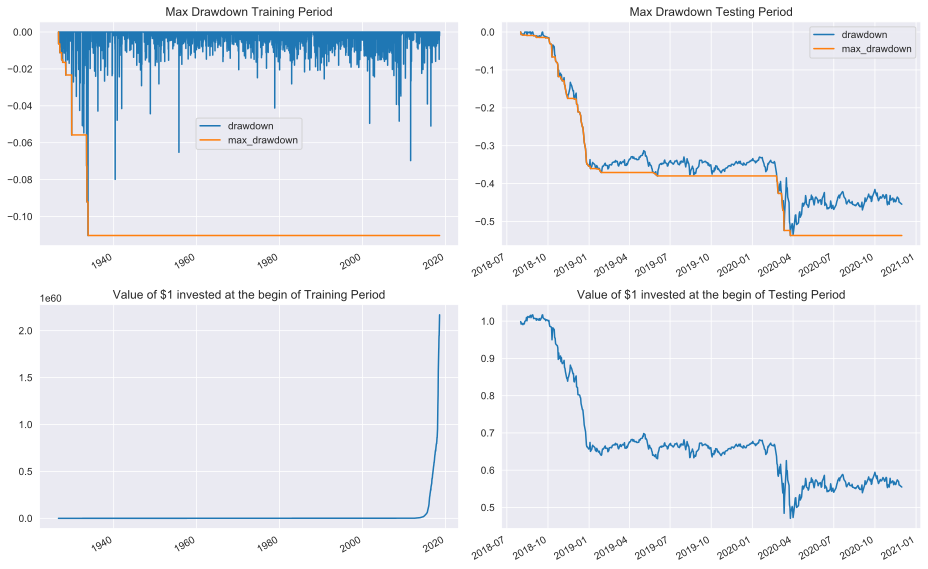

In [171]:
perf_stats_train, drawdowns_df_train, index_lvl_train = performance_stats(train['pred_return']/100)
perf_stats_test, drawdowns_df_test, index_lvl_test = performance_stats(test['pred_return']/100)

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(13,8))

drawdowns_df_train.plot(ax = axs[0,0])
axs[0,0].title.set_text('Max Drawdown Training Period')

index_lvl_train.plot(ax = axs[1,0])
axs[1,0].title.set_text('Value of $1 invested at the begin of Training Period')

drawdowns_df_test.plot(ax = axs[0,1])
axs[0,1].title.set_text('Max Drawdown Testing Period')

index_lvl_test.plot(ax = axs[1,1])
axs[1,1].title.set_text('Value of $1 invested at the begin of Testing Period')

plt.tight_layout()

### Final Conclusion  Q -10

***On the model*** 

* ***The random forest model was unable to predict the direction of the markets.***
* ***The validation curves clearly indicates that there is no point of further experimenting with hyperparameters, as validation scores are flat acorss grid.***
* ***Given the validation socres themselves are not moving at all from 0.5 suggests that all the performance related charts from now on would reflect similar sentiment when it comes to accuracy and performance of the model.***


***Further Improvements which could improve model performance.***

* ***Instead of using 5 lags in market return, try to use aggregated features on signal for previous days.***
* ***Instead of just focusing on the accuracy, we should use a diffrent scorer like precision to miminise false positives whch can bring reduce max drawdown numbers.***
* ***The biggest improvment we beleve we can bring in is by shorten the training period from 1926 to somewhere around after 1970's***
* ***Trying diffrent algorithms like XG-Boost and Adaboost which are sequential in nature and built upon the errors of the previous iteration's errors***


### Final Conclusion  Q -13

***The above charts shows the out of sample results for time periods 2018-20 are not improving at all, beacuse of ovrfitting in the training period and aboslutely no predictive power of the ml model.***